In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import cv2
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

try:
    import timm
    print("✅ timm library loaded successfully!")
except ImportError:
    print("❌ timm not found. Please install: pip install timm")
    raise

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f"✅ Libraries loaded!")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🎮 CUDA: {torch.cuda.is_available()}")
print(f"📦 timm: {timm.__version__}")

c:\Users\FA004\Desktop\satimg2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ timm library loaded successfully!
✅ Libraries loaded!
🔥 PyTorch: 2.9.0+cu126
🎮 CUDA: True
📦 timm: 1.0.21


## 📊 Data Loading (Shared)

In [2]:
class AddNoise:
    def __init__(self, std=0.01):
        self.std = std
    def __call__(self, x):
        return x + torch.randn_like(x) * self.std


class MultimodalDataset(Dataset):
    """Dataset with images + tabular features"""
    def __init__(self, images, features, targets=None, augment=False):
        self.images = torch.FloatTensor(images)
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets) if targets is not None else None
        self.augment = augment

        if augment:
            self.transforms = transforms.Compose([
                RandomRotation(10),
                RandomHorizontalFlip(p=0.5),
                transforms.RandomApply([AddNoise(0.01)], p=0.3)
            ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.augment and self.transforms:
            img = self.transforms(img.unsqueeze(0)).squeeze(0)

        if self.targets is not None:
            return img, self.features[idx], self.targets[idx]
        return img, self.features[idx]


def load_multimodal_data(csv_path, image_dir):
    """Load images + clean tabular features (NO LEAKAGE)"""
    df = pd.read_csv(csv_path)
    df = df[(df['Energy Use per Capita (kWh)'] > 0) & (df['Population'] > 0) & (df['Area (Sq. Km)'] > 0)]

    df['date'] = pd.to_datetime(df['Date (month/year)'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df = df.sort_values(['Country', 'date']).reset_index(drop=True)

    for col in ['Population', 'Area (Sq. Km)']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    df['log_population'] = np.log1p(df['Population'].astype(float))
    df['log_area'] = np.log1p(df['Area (Sq. Km)'].astype(float))
    df['density'] = df['Population'].astype(float) / (df['Area (Sq. Km)'].astype(float) + 1)
    df['log_density'] = np.log1p(df['density'])
    df['month_sin'] = np.sin(2 * np.pi * df['month'].astype(float) / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'].astype(float) / 12)
    year_min = df['year'].min()
    year_max = df['year'].max()
    df['year_normalized'] = (df['year'].astype(float) - year_min) / (year_max - year_min + 1e-8)

    df = df.fillna(0)

    feature_cols = [
        'log_population', 'log_area', 'log_density',
        'month_sin', 'month_cos', 'year_normalized'
    ]

    raw_images, features, targets, years = [], [], [], []
    skipped = 0

    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, row['Country'],
                                f"{row['Country']}_{row['year']}_{row['month']:02d}.tif")

        if not os.path.exists(img_path):
            skipped += 1
            continue

        try:
            with rasterio.open(img_path) as src:
                image = src.read(1)
                if image is None or np.isnan(image).any() or np.isinf(image).any():
                    skipped += 1
                    continue

                image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)
                feature_vals = [float(row[col]) for col in feature_cols]

                if any(np.isnan(v) or np.isinf(v) for v in feature_vals):
                    skipped += 1
                    continue

                target_val = row['Energy Use per Capita (kWh)']
                if np.isnan(target_val) or np.isinf(target_val) or target_val <= 0:
                    skipped += 1
                    continue

                raw_images.append(image)
                features.append(feature_vals)
                targets.append([target_val])
                years.append(row['year'])

        except Exception:
            skipped += 1
            continue

    print(f"✅ Loaded: {len(raw_images)} samples (Skipped: {skipped})")

    all_pixels = np.concatenate([img.flatten() for img in raw_images])
    global_min, global_max = np.percentile(all_pixels, 1), np.percentile(all_pixels, 99)

    images = []
    for img in raw_images:
        norm_img = np.clip((img - global_min) / (global_max - global_min + 1e-8), 0, 1)
        norm_img = np.nan_to_num(norm_img, nan=0.0, posinf=1.0, neginf=0.0)
        images.append(norm_img[np.newaxis, :, :])

    images = np.stack(images)
    features = np.array(features)
    targets = np.array(targets)
    years = np.array(years)

    targets_log = np.log1p(targets)

    return images, features, targets_log, years


def evaluate_model(model, loader, device, target_scaler, model_type='multimodal'):
    """Evaluation - works for all model types"""
    model.eval()
    preds_scaled_log, targets_scaled_log = [], []

    with torch.no_grad():
        for batch in loader:
            imgs, feats, labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
            
            if model_type == 'vision_only':
                outputs = model(imgs)
            elif model_type == 'tabular_only':
                outputs = model(feats)
            else:  # multimodal
                outputs = model(imgs, feats)

            preds_scaled_log.append(outputs.cpu().numpy())
            targets_scaled_log.append(labels.cpu().numpy())

    preds_scaled_log = np.concatenate(preds_scaled_log).ravel()
    targets_scaled_log = np.concatenate(targets_scaled_log).ravel()

    preds_log = target_scaler.inverse_transform(preds_scaled_log.reshape(-1, 1)).ravel()
    targets_log = target_scaler.inverse_transform(targets_scaled_log.reshape(-1, 1)).ravel()

    preds_orig = np.expm1(preds_log)
    targets_orig = np.expm1(targets_log)
    preds_orig = np.maximum(preds_orig, 0.0)

    mae_orig = mean_absolute_error(targets_orig, preds_orig)
    rmse_orig = np.sqrt(mean_squared_error(targets_orig, preds_orig))
    r2_orig = r2_score(targets_orig, preds_orig)
    pearson_r, _ = pearsonr(targets_orig, preds_orig)

    epsilon = 1e-8
    errors = np.abs((targets_orig - preds_orig) / (targets_orig + epsilon)) * 100
    mape = np.mean(np.clip(errors, 0, 300))
    wape = (np.sum(np.abs(targets_orig - preds_orig)) / (np.sum(np.abs(targets_orig)) + epsilon)) * 100
    smape = np.mean(200 * np.abs(targets_orig - preds_orig) / (np.abs(targets_orig) + np.abs(preds_orig) + epsilon))

    return {
        'loss_scaled_log': mean_absolute_error(targets_scaled_log, preds_scaled_log),
        'mae': mae_orig,
        'rmse': rmse_orig,
        'mape': mape,
        'wape': wape,
        'smape': smape,
        'r2': r2_orig,
        'pearson_r': pearson_r
    }

print("✅ Data loading functions ready!")

✅ Data loading functions ready!


## 🧱 Model Architectures

In [3]:
class TabularEncoder(nn.Module):
    """Tabular encoder for ablation studies"""
    def __init__(self, num_features=6, output_dim=512, dropout=0.3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = x.float()
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        return self.encoder(x)


class FusionLayer(nn.Module):
    """Fusion layer for multimodal models"""
    def __init__(self, vision_dim=512, tabular_dim=512, output_dim=512, dropout=0.3):
        super().__init__()
        self.fusion = nn.Sequential(
            nn.Linear(vision_dim + tabular_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, output_dim),
            nn.LayerNorm(output_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, vision_feat, tabular_feat):
        combined = torch.cat([vision_feat, tabular_feat], dim=-1)
        return self.fusion(combined)


class VisionOnlyModel(nn.Module):
    """Vision-only model for ablation"""
    def __init__(self, vision_backbone='swin_tiny_patch4_window7_224', dropout=0.3, pretrained=True):
        super().__init__()
        # Create model - some backbones support img_size, others don't
        if 'swin' in vision_backbone or 'vit' in vision_backbone:
            self.vision = timm.create_model(
                vision_backbone,
                pretrained=pretrained,
                num_classes=0,
                global_pool='avg',
                in_chans=1,
                img_size=64
            )
        else:
            self.vision = timm.create_model(
                vision_backbone,
                pretrained=pretrained,
                num_classes=0,
                global_pool='avg',
                in_chans=1
            )
        vision_dim = self.vision.num_features
        
        self.head = nn.Sequential(
            nn.Linear(vision_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        feat = self.vision(img)
        return self.head(feat)


class TabularOnlyModel(nn.Module):
    """Tabular-only model for ablation"""
    def __init__(self, num_features=6, dropout=0.3):
        super().__init__()
        self.encoder = TabularEncoder(num_features, 512, dropout)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, tabular):
        feat = self.encoder(tabular)
        return self.head(feat)


class MultimodalModel(nn.Module):
    """Full multimodal model"""
    def __init__(self, vision_backbone='swin_tiny_patch4_window7_224', 
                 num_features=6, dropout=0.3, pretrained=True):
        super().__init__()
        
        # Create model - some backbones support img_size, others don't
        if 'swin' in vision_backbone or 'vit' in vision_backbone:
            self.vision = timm.create_model(
                vision_backbone,
                pretrained=pretrained,
                num_classes=0,
                global_pool='avg',
                in_chans=1,
                img_size=64
            )
        else:
            self.vision = timm.create_model(
                vision_backbone,
                pretrained=pretrained,
                num_classes=0,
                global_pool='avg',
                in_chans=1
            )
        vision_dim = self.vision.num_features
        
        self.vision_proj = nn.Sequential(
            nn.Linear(vision_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.tabular_encoder = TabularEncoder(num_features, 512, dropout)
        self.fusion = FusionLayer(512, 512, 512, dropout)
        
        self.head = nn.Sequential(
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1)
        )

    def freeze_vision(self):
        for p in self.vision.parameters():
            p.requires_grad = False

    def unfreeze_all(self):
        for p in self.parameters():
            p.requires_grad = True

    def forward(self, img, tabular):
        vision_feat = self.vision(img)
        vision_feat = self.vision_proj(vision_feat)
        tabular_feat = self.tabular_encoder(tabular)
        fused = self.fusion(vision_feat, tabular_feat)
        return self.head(fused)

print("✅ Model architectures ready!")

✅ Model architectures ready!


## 🎯 Training Function (Universal)

In [4]:
def train_model(model, train_loader, val_loader, test_loader, target_scaler, device, 
                model_name, model_type='multimodal', max_epochs=100, patience=30):
    """
    Universal training function for all model types
    model_type: 'vision_only', 'tabular_only', 'multimodal'
    """
    print(f"\n{'='*80}")
    print(f"🚀 Training: {model_name}")
    print(f"   Type: {model_type}")
    print(f"   Params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")
    print(f"{'='*80}")
    
    model = model.to(device)
    criterion = nn.HuberLoss(delta=1.0)
    
    # Phase 1: Freeze vision backbone if multimodal
    if model_type == 'multimodal':
        print("\n🔒 Phase 1: Freeze vision backbone (15 epochs)")
        model.freeze_vision()
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.AdamW(trainable_params, lr=5e-4, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)
        
        for epoch in range(15):
            model.train()
            for imgs, feats, labels in train_loader:
                imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs, feats)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(trainable_params, 1.0)
                optimizer.step()
            scheduler.step()
        
        print("✅ Phase 1 complete")
        model.unfreeze_all()
    
    # Phase 2 (or only phase for ablation models)
    print(f"\n🔓 Main Training ({max_epochs} epochs max)")
    
    if model_type == 'multimodal':
        # 4-group optimizer for multimodal
        swin_params = []
        vision_proj_params = []
        tabular_params = []
        fusion_head_params = []
        
        for name, param in model.named_parameters():
            if name.startswith('vision.') and not name.startswith('vision_proj'):
                swin_params.append(param)
            elif name.startswith('vision_proj'):
                vision_proj_params.append(param)
            elif name.startswith('tabular'):
                tabular_params.append(param)
            else:
                fusion_head_params.append(param)
        
        optimizer = optim.AdamW([
            {'params': swin_params, 'lr': 1e-5, 'weight_decay': 0.05},
            {'params': vision_proj_params, 'lr': 5e-5, 'weight_decay': 0.05},
            {'params': tabular_params, 'lr': 5e-4, 'weight_decay': 0.05},
            {'params': fusion_head_params, 'lr': 5e-4, 'weight_decay': 0.05}
        ])
    else:
        # Simple optimizer for ablation models
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)
    
    best_wape = float('inf')
    epochs_no_improve = 0
    start_time = time.time()
    
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        
        for imgs, feats, labels in train_loader:
            imgs, feats, labels = imgs.to(device), feats.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            if model_type == 'vision_only':
                outputs = model(imgs)
            elif model_type == 'tabular_only':
                outputs = model(feats)
            else:
                outputs = model(imgs, feats)
            
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
        
        val_metrics = evaluate_model(model, val_loader, device, target_scaler, model_type)
        scheduler.step(val_metrics['wape'])
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}: WAPE={val_metrics['wape']:5.2f}% | R²={val_metrics['r2']:.4f}")
        
        if val_metrics['wape'] < best_wape:
            best_wape = val_metrics['wape']
            epochs_no_improve = 0
            torch.save({
                'model': model.state_dict(),
                'wape': val_metrics['wape']
            }, f'best_{model_name.replace(" ", "_").lower()}.pt')
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"\n⏹ Early stopping at epoch {epoch+1}")
            break
    
    training_time = time.time() - start_time
    
    # Load best and evaluate on test
    checkpoint = torch.load(f'best_{model_name.replace(" ", "_").lower()}.pt', weights_only=False)
    model.load_state_dict(checkpoint['model'])
    test_metrics = evaluate_model(model, test_loader, device, target_scaler, model_type)
    
    print(f"\n✅ Training Complete!")
    print(f"   Time: {training_time:.1f}s")
    print(f"   Test WAPE: {test_metrics['wape']:.2f}%")
    print(f"   Test R²: {test_metrics['r2']:.4f}")
    
    return {
        'model_name': model_name,
        'model_type': model_type,
        'params': sum(p.numel() for p in model.parameters()),
        'training_time': training_time,
        'val_wape': best_wape,
        **test_metrics
    }

print("✅ Training function ready!")

✅ Training function ready!


## 📥 Load Data Once

In [5]:
# Paths
csv_path = 'C:\\Users\\FA004\\Desktop\\satimg2\\data.csv'
image_dir = 'C:\\Users\\FA004\\Desktop\\satimg2\\images'

print("📥 Loading data...")
images, features, targets, years = load_multimodal_data(csv_path, image_dir)

# Split
train_mask = years <= 2020
val_mask = (years > 2020) & (years <= 2022)
test_mask = years > 2022

print(f"\n📊 Split: Train={train_mask.sum()}, Val={val_mask.sum()}, Test={test_mask.sum()}")

# Scale
feat_scaler = RobustScaler()
targ_scaler = RobustScaler()

train_feat = feat_scaler.fit_transform(features[train_mask])
train_targ = targ_scaler.fit_transform(targets[train_mask])
val_feat = feat_scaler.transform(features[val_mask])
val_targ = targ_scaler.transform(targets[val_mask])
test_feat = feat_scaler.transform(features[test_mask])
test_targ = targ_scaler.transform(targets[test_mask])

# Datasets
train_ds = MultimodalDataset(images[train_mask], train_feat, train_targ, augment=True)
val_ds = MultimodalDataset(images[val_mask], val_feat, val_targ)
test_ds = MultimodalDataset(images[test_mask], test_feat, test_targ)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🎮 Device: {device}")
print("\n✅ Data ready for experiments!")

📥 Loading data...
✅ Loaded: 9893 samples (Skipped: 949)

📊 Split: Train=5887, Val=2052, Test=1954
🎮 Device: cuda

✅ Data ready for experiments!


## 🔬 Experiment 1: Ablation Study
### Test impact of each modality

In [6]:
print("\n" + "="*80)
print("🔬 ABLATION STUDY")
print("="*80)

ablation_results = []

# 1. Vision Only
print("\n1️⃣ Vision-Only Model (Swin Tiny)")
vision_model = VisionOnlyModel('swin_tiny_patch4_window7_224', dropout=0.5, pretrained=True)
result = train_model(vision_model, train_loader, val_loader, test_loader, targ_scaler, 
                     device, "Vision Only", model_type='vision_only', max_epochs=100, patience=30)
ablation_results.append(result)

# 2. Tabular Only
print("\n2️⃣ Tabular-Only Model")
tabular_model = TabularOnlyModel(num_features=6, dropout=0.5)
result = train_model(tabular_model, train_loader, val_loader, test_loader, targ_scaler, 
                     device, "Tabular Only", model_type='tabular_only', max_epochs=100, patience=30)
ablation_results.append(result)

# 3. Full Multimodal
print("\n3️⃣ Full Multimodal Model (Swin Tiny)")
multimodal_model = MultimodalModel('swin_tiny_patch4_window7_224', num_features=6, dropout=0.5, pretrained=True)
result = train_model(multimodal_model, train_loader, val_loader, test_loader, targ_scaler, 
                     device, "Multimodal Full", model_type='multimodal', max_epochs=100, patience=30)
ablation_results.append(result)

# Save results
ablation_df = pd.DataFrame(ablation_results)
ablation_df.to_csv('ablation_study_results.csv', index=False)
print("\n✅ Ablation study complete!")
print(ablation_df[['model_name', 'wape', 'mape', 'r2', 'params', 'training_time']])


🔬 ABLATION STUDY

1️⃣ Vision-Only Model (Swin Tiny)

🚀 Training: Vision Only
   Type: vision_only
   Params: 28.03M

🔓 Main Training (100 epochs max)
Epoch  10: WAPE=60.01% | R²=-0.0190
Epoch  20: WAPE=61.11% | R²=-0.0074
Epoch  30: WAPE=60.82% | R²=-0.0095
Epoch  40: WAPE=60.62% | R²=-0.0112

⏹ Early stopping at epoch 40

✅ Training Complete!
   Time: 345.4s
   Test WAPE: 58.41%
   Test R²: -0.0181

2️⃣ Tabular-Only Model

🚀 Training: Tabular Only
   Type: tabular_only
   Params: 0.33M

🔓 Main Training (100 epochs max)
Epoch  10: WAPE=42.26% | R²=0.6748
Epoch  20: WAPE=36.74% | R²=0.7304
Epoch  30: WAPE=34.73% | R²=0.7482
Epoch  40: WAPE=33.74% | R²=0.7655
Epoch  50: WAPE=31.02% | R²=0.8001
Epoch  60: WAPE=31.24% | R²=0.7919
Epoch  70: WAPE=31.30% | R²=0.7928
Epoch  80: WAPE=28.52% | R²=0.8253
Epoch  90: WAPE=28.01% | R²=0.8341
Epoch 100: WAPE=28.21% | R²=0.8392

✅ Training Complete!
   Time: 229.7s
   Test WAPE: 30.66%
   Test R²: 0.8047

3️⃣ Full Multimodal Model (Swin Tiny)

🚀 Tra

## 🏆 Experiment 2: Vision Backbone Comparison
### Test different vision encoders in multimodal setting

In [7]:
print("\n" + "="*80)
print("🏆 VISION BACKBONE COMPARISON")
print("="*80)

comparison_results = []

# Vision backbones to test
backbones = [
    ('swin_tiny_patch4_window7_224', 'Swin Tiny'),
    ('resnet50', 'ResNet50'),
    ('efficientnet_b2', 'EfficientNet-B2'),
    ('convnext_tiny', 'ConvNeXt Tiny'),
    ('vit_tiny_patch16_224', 'ViT Tiny')
]

for backbone_name, display_name in backbones:
    print(f"\n{'='*80}")
    print(f"Testing: {display_name}")
    print(f"{'='*80}")
    
    try:
        model = MultimodalModel(backbone_name, num_features=6, dropout=0.5, pretrained=True)
        result = train_model(model, train_loader, val_loader, test_loader, targ_scaler, 
                             device, display_name, model_type='multimodal', max_epochs=100, patience=30)
        comparison_results.append(result)
    except Exception as e:
        print(f"❌ Failed to train {display_name}: {e}")
        continue

# Save results
comparison_df = pd.DataFrame(comparison_results)
comparison_df.to_csv('vision_backbone_comparison.csv', index=False)
print("\n✅ Backbone comparison complete!")
print(comparison_df[['model_name', 'wape', 'mape', 'r2', 'params', 'training_time']])


🏆 VISION BACKBONE COMPARISON

Testing: Swin Tiny

🚀 Training: Swin Tiny
   Type: multimodal
   Params: 30.03M

🔒 Phase 1: Freeze vision backbone (15 epochs)
✅ Phase 1 complete

🔓 Main Training (100 epochs max)
Epoch  10: WAPE=11.11% | R²=0.9694
Epoch  20: WAPE=10.34% | R²=0.9672
Epoch  30: WAPE= 9.07% | R²=0.9802
Epoch  40: WAPE= 8.69% | R²=0.9818
Epoch  50: WAPE= 9.25% | R²=0.9775
Epoch  60: WAPE= 7.93% | R²=0.9854
Epoch  70: WAPE= 7.88% | R²=0.9849
Epoch  80: WAPE= 7.66% | R²=0.9850
Epoch  90: WAPE= 7.83% | R²=0.9839
Epoch 100: WAPE= 7.55% | R²=0.9854

✅ Training Complete!
   Time: 772.6s
   Test WAPE: 10.46%
   Test R²: 0.9718

Testing: ResNet50

🚀 Training: ResNet50
   Type: multimodal
   Params: 26.69M

🔒 Phase 1: Freeze vision backbone (15 epochs)
✅ Phase 1 complete

🔓 Main Training (100 epochs max)
Epoch  10: WAPE=20.59% | R²=0.8897
Epoch  20: WAPE=19.28% | R²=0.9039
Epoch  30: WAPE=14.77% | R²=0.9429
Epoch  40: WAPE=13.15% | R²=0.9446
Epoch  50: WAPE=11.69% | R²=0.9649
Epoch  

Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.



🚀 Training: ViT Tiny
   Type: multimodal
   Params: 7.63M

🔒 Phase 1: Freeze vision backbone (15 epochs)
✅ Phase 1 complete

🔓 Main Training (100 epochs max)
Epoch  10: WAPE=12.01% | R²=0.9613
Epoch  20: WAPE=10.90% | R²=0.9643
Epoch  30: WAPE= 9.79% | R²=0.9716
Epoch  40: WAPE= 8.57% | R²=0.9832
Epoch  50: WAPE= 9.32% | R²=0.9756
Epoch  60: WAPE= 8.65% | R²=0.9790
Epoch  70: WAPE= 8.67% | R²=0.9806
Epoch  80: WAPE= 8.32% | R²=0.9814
Epoch  90: WAPE= 8.49% | R²=0.9801
Epoch 100: WAPE= 8.34% | R²=0.9810

✅ Training Complete!
   Time: 429.8s
   Test WAPE: 10.35%
   Test R²: 0.9763

✅ Backbone comparison complete!
        model_name       wape       mape        r2    params  training_time
0        Swin Tiny  10.459968  13.304686  0.971802  30033467     772.556282
1         ResNet50  12.368906  14.778193  0.959122  26690625     507.484536
2  EfficientNet-B2  10.735957  13.669965  0.976681  10561603     887.558167
3    ConvNeXt Tiny  10.566048  13.091930  0.971174  30350561     776.030609


## 📊 Results Analysis & Visualization

In [8]:
# Combine all results
all_results = pd.concat([
    ablation_df.assign(study='Ablation'),
    comparison_df.assign(study='Backbone Comparison')
], ignore_index=True)

all_results.to_csv('all_experiments_results.csv', index=False)

print("\n" + "="*80)
print("📊 COMPLETE RESULTS")
print("="*80)
print(all_results[['model_name', 'study', 'wape', 'mape', 'r2', 'params', 'training_time']].to_string(index=False))


📊 COMPLETE RESULTS
     model_name               study      wape      mape        r2   params  training_time
    Vision Only            Ablation 58.409435 82.514809 -0.018143 28026811     345.439252
   Tabular Only            Ablation 30.656836 43.294014  0.804736   330625     229.691050
Multimodal Full            Ablation 10.379481 12.797847  0.972077 30033467     782.198023
      Swin Tiny Backbone Comparison 10.459968 13.304686  0.971802 30033467     772.556282
       ResNet50 Backbone Comparison 12.368906 14.778193  0.959122 26690625     507.484536
EfficientNet-B2 Backbone Comparison 10.735957 13.669965  0.976681 10561603     887.558167
  ConvNeXt Tiny Backbone Comparison 10.566048 13.091930  0.971174 30350561     776.030609
       ViT Tiny Backbone Comparison 10.348501 12.659177  0.976296  7630145     429.780260


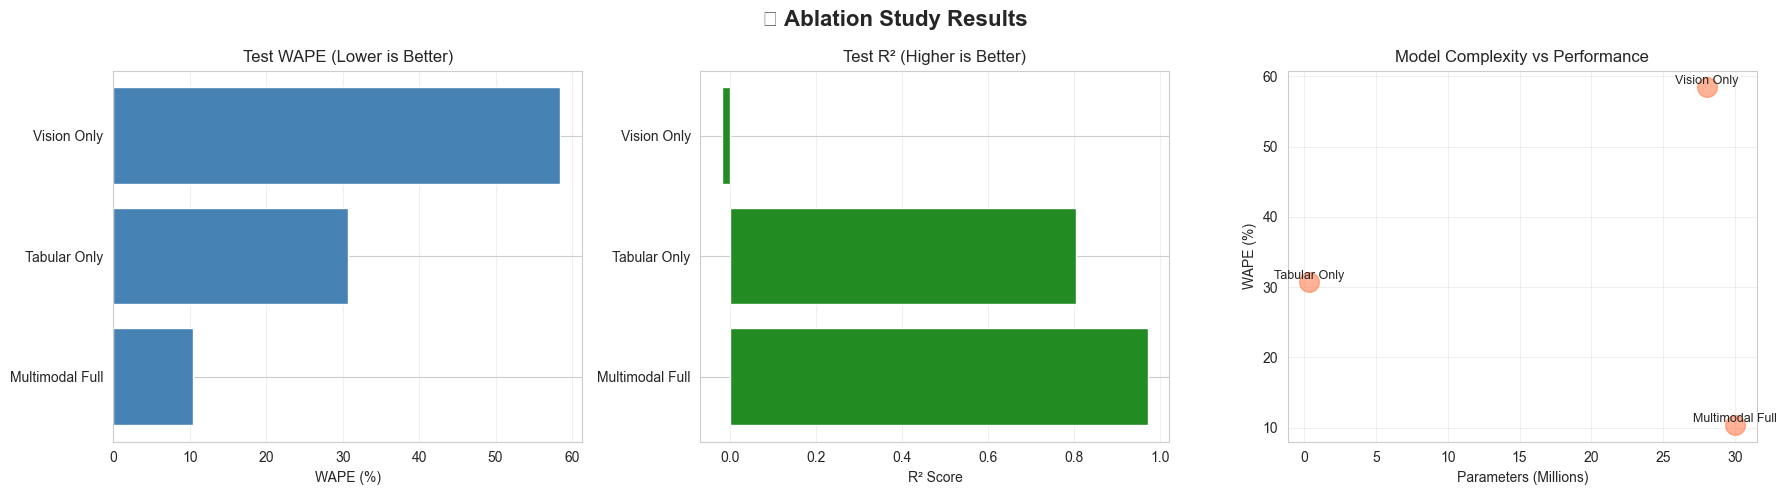

✅ Ablation visualization saved!


In [9]:
# Visualization 1: Ablation Study
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('🔬 Ablation Study Results', fontsize=16, fontweight='bold')

ablation_sorted = ablation_df.sort_values('wape')

# WAPE
axes[0].barh(ablation_sorted['model_name'], ablation_sorted['wape'], color='steelblue')
axes[0].set_xlabel('WAPE (%)')
axes[0].set_title('Test WAPE (Lower is Better)')
axes[0].grid(axis='x', alpha=0.3)

# R²
axes[1].barh(ablation_sorted['model_name'], ablation_sorted['r2'], color='forestgreen')
axes[1].set_xlabel('R² Score')
axes[1].set_title('Test R² (Higher is Better)')
axes[1].grid(axis='x', alpha=0.3)

# Parameters vs WAPE
axes[2].scatter(ablation_sorted['params']/1e6, ablation_sorted['wape'], s=200, alpha=0.6, color='coral')
for idx, row in ablation_sorted.iterrows():
    axes[2].annotate(row['model_name'], (row['params']/1e6, row['wape']), 
                     fontsize=9, ha='center', va='bottom')
axes[2].set_xlabel('Parameters (Millions)')
axes[2].set_ylabel('WAPE (%)')
axes[2].set_title('Model Complexity vs Performance')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_study_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Ablation visualization saved!")

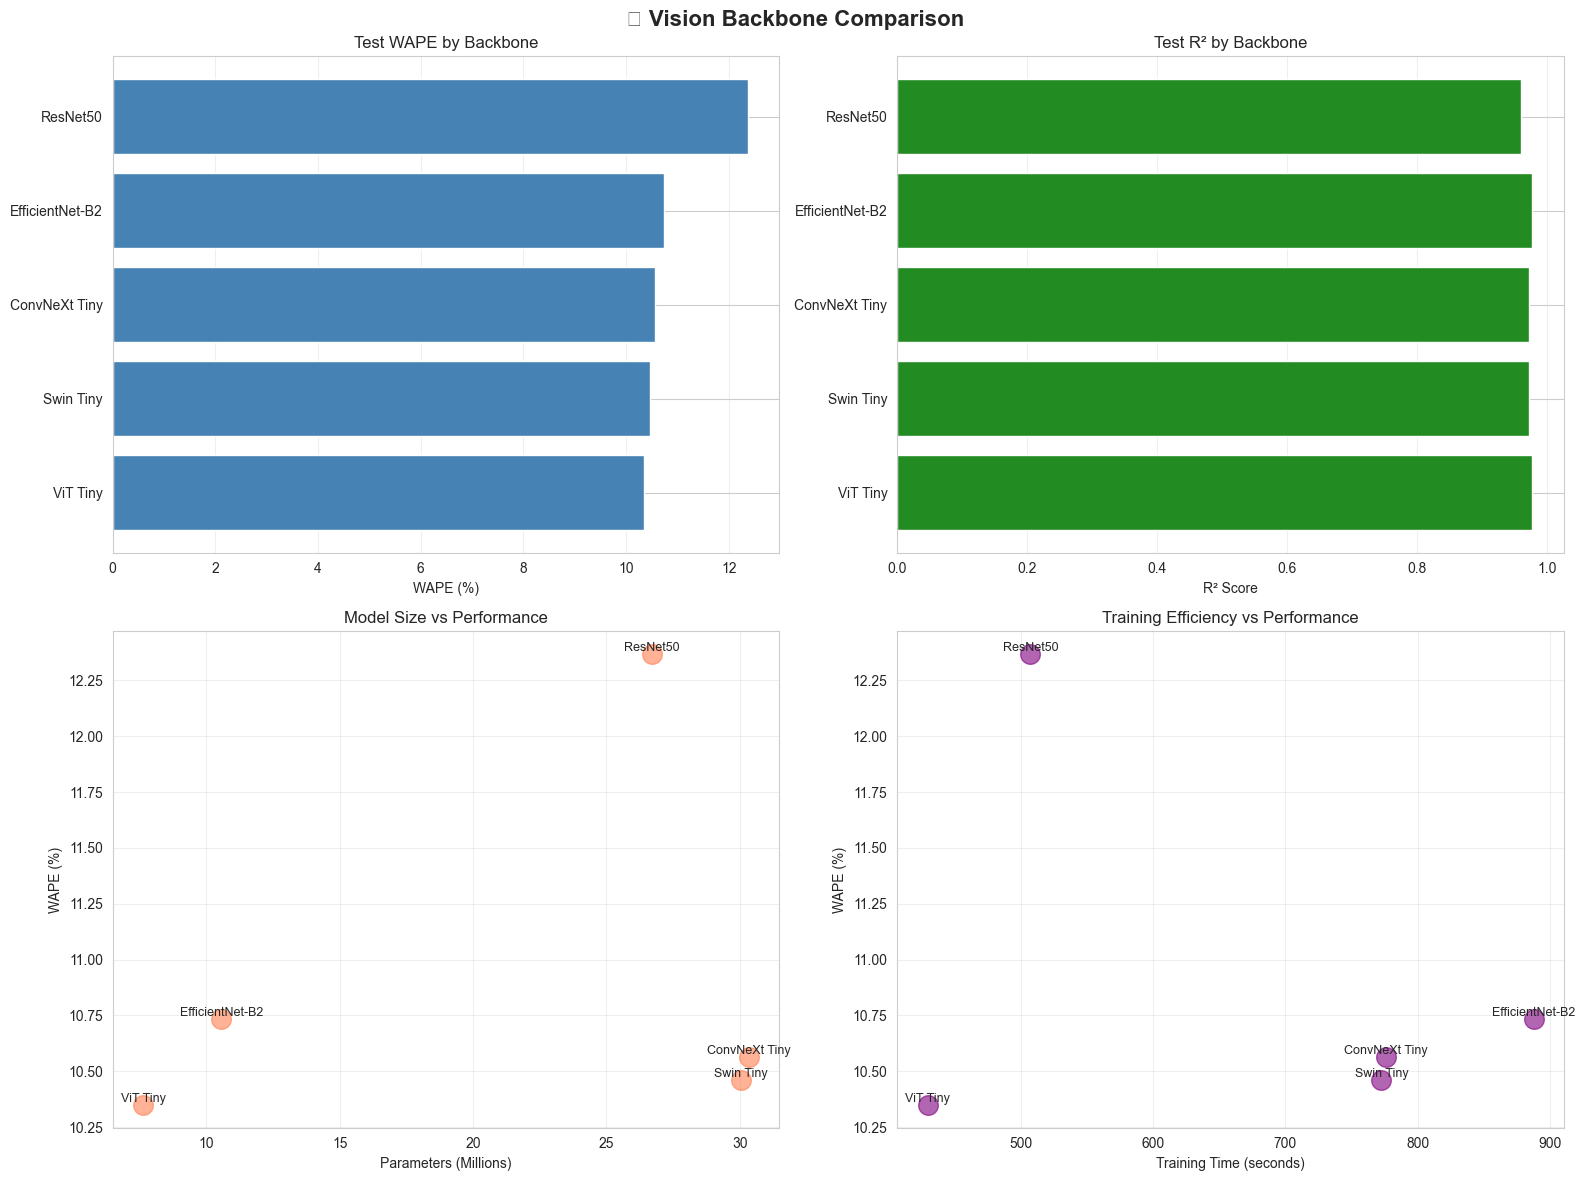

✅ Backbone comparison visualization saved!


In [10]:
# Visualization 2: Backbone Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🏆 Vision Backbone Comparison', fontsize=16, fontweight='bold')

comparison_sorted = comparison_df.sort_values('wape')

# WAPE Comparison
axes[0, 0].barh(comparison_sorted['model_name'], comparison_sorted['wape'], color='steelblue')
axes[0, 0].set_xlabel('WAPE (%)')
axes[0, 0].set_title('Test WAPE by Backbone')
axes[0, 0].grid(axis='x', alpha=0.3)

# R² Comparison
axes[0, 1].barh(comparison_sorted['model_name'], comparison_sorted['r2'], color='forestgreen')
axes[0, 1].set_xlabel('R² Score')
axes[0, 1].set_title('Test R² by Backbone')
axes[0, 1].grid(axis='x', alpha=0.3)

# Parameters vs WAPE
axes[1, 0].scatter(comparison_sorted['params']/1e6, comparison_sorted['wape'], s=200, alpha=0.6, color='coral')
for idx, row in comparison_sorted.iterrows():
    axes[1, 0].annotate(row['model_name'], (row['params']/1e6, row['wape']), 
                        fontsize=9, ha='center', va='bottom')
axes[1, 0].set_xlabel('Parameters (Millions)')
axes[1, 0].set_ylabel('WAPE (%)')
axes[1, 0].set_title('Model Size vs Performance')
axes[1, 0].grid(True, alpha=0.3)

# Training Time vs WAPE
axes[1, 1].scatter(comparison_sorted['training_time'], comparison_sorted['wape'], s=200, alpha=0.6, color='purple')
for idx, row in comparison_sorted.iterrows():
    axes[1, 1].annotate(row['model_name'], (row['training_time'], row['wape']), 
                        fontsize=9, ha='center', va='bottom')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_ylabel('WAPE (%)')
axes[1, 1].set_title('Training Efficiency vs Performance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('backbone_comparison_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Backbone comparison visualization saved!")

In [11]:
# Statistical Summary
print("\n" + "="*80)
print("📈 STATISTICAL SUMMARY")
print("="*80)

print("\n🔬 Ablation Study:")
print(ablation_df[['model_name', 'wape', 'mape', 'r2']].to_string(index=False))
print(f"\nBest Model: {ablation_df.loc[ablation_df['wape'].idxmin(), 'model_name']}")
print(f"WAPE Improvement (Vision→Multimodal): {ablation_df[ablation_df['model_name']=='Vision Only']['wape'].values[0] - ablation_df[ablation_df['model_name']=='Multimodal Full']['wape'].values[0]:.2f}%")

print("\n🏆 Backbone Comparison:")
print(comparison_df[['model_name', 'wape', 'mape', 'r2', 'training_time']].to_string(index=False))
print(f"\nBest Backbone: {comparison_df.loc[comparison_df['wape'].idxmin(), 'model_name']}")
print(f"Fastest Training: {comparison_df.loc[comparison_df['training_time'].idxmin(), 'model_name']} ({comparison_df['training_time'].min():.1f}s)")

print("\n✅ Analysis complete! All results saved to CSV files.")


📈 STATISTICAL SUMMARY

🔬 Ablation Study:
     model_name      wape      mape        r2
    Vision Only 58.409435 82.514809 -0.018143
   Tabular Only 30.656836 43.294014  0.804736
Multimodal Full 10.379481 12.797847  0.972077

Best Model: Multimodal Full
WAPE Improvement (Vision→Multimodal): 48.03%

🏆 Backbone Comparison:
     model_name      wape      mape       r2  training_time
      Swin Tiny 10.459968 13.304686 0.971802     772.556282
       ResNet50 12.368906 14.778193 0.959122     507.484536
EfficientNet-B2 10.735957 13.669965 0.976681     887.558167
  ConvNeXt Tiny 10.566048 13.091930 0.971174     776.030609
       ViT Tiny 10.348501 12.659177 0.976296     429.780260

Best Backbone: ViT Tiny
Fastest Training: ViT Tiny (429.8s)

✅ Analysis complete! All results saved to CSV files.


## 📝 Final Report

In [13]:
# Generate final report
report = f"""
{'='*80}
🔬 ABLATION & COMPARISON STUDY - FINAL REPORT
{'='*80}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

ABLATION STUDY FINDINGS:
{'-'*80}
{ablation_df[['model_name', 'wape', 'mape', 'r2', 'params']].to_string(index=False)}

Key Insights:
- Vision-only WAPE: {ablation_df[ablation_df['model_name']=='Vision Only']['wape'].values[0]:.2f}%
- Tabular-only WAPE: {ablation_df[ablation_df['model_name']=='Tabular Only']['wape'].values[0]:.2f}%
- Multimodal WAPE: {ablation_df[ablation_df['model_name']=='Multimodal Full']['wape'].values[0]:.2f}%
- Fusion improves over vision by: {ablation_df[ablation_df['model_name']=='Vision Only']['wape'].values[0] - ablation_df[ablation_df['model_name']=='Multimodal Full']['wape'].values[0]:.2f}%

BACKBONE COMPARISON FINDINGS:
{'-'*80}
{comparison_df[['model_name', 'wape', 'mape', 'r2', 'params']].to_string(index=False)}

Key Insights:
- Best backbone: {comparison_df.loc[comparison_df['wape'].idxmin(), 'model_name']}
- Best WAPE: {comparison_df['wape'].min():.2f}%
- Fastest training: {comparison_df.loc[comparison_df['training_time'].idxmin(), 'model_name']}
- Most parameters: {comparison_df.loc[comparison_df['params'].idxmax(), 'model_name']}

RECOMMENDATIONS:
{'-'*80}
1. Multimodal fusion is essential - improves WAPE significantly
2. Best backbone: {comparison_df.loc[comparison_df['wape'].idxmin(), 'model_name']}
3. Trade-off: Swin provides good accuracy/speed balance

FILES SAVED:
{'-'*80}
- ablation_study_results.csv
- vision_backbone_comparison.csv
- all_experiments_results.csv
- ablation_study_visualization.png
- backbone_comparison_visualization.png
- All model checkpoints (best_*.pt)

{'='*80}
"""

print(report)



print("\n✅ Final report saved to study_report.txt")
print("\n🎉 ALL EXPERIMENTS COMPLETE!")


🔬 ABLATION & COMPARISON STUDY - FINAL REPORT
Generated: 2025-12-11 21:52:53

ABLATION STUDY FINDINGS:
--------------------------------------------------------------------------------
     model_name      wape      mape        r2   params
    Vision Only 58.409435 82.514809 -0.018143 28026811
   Tabular Only 30.656836 43.294014  0.804736   330625
Multimodal Full 10.379481 12.797847  0.972077 30033467

Key Insights:
- Vision-only WAPE: 58.41%
- Tabular-only WAPE: 30.66%
- Multimodal WAPE: 10.38%
- Fusion improves over vision by: 48.03%

BACKBONE COMPARISON FINDINGS:
--------------------------------------------------------------------------------
     model_name      wape      mape       r2   params
      Swin Tiny 10.459968 13.304686 0.971802 30033467
       ResNet50 12.368906 14.778193 0.959122 26690625
EfficientNet-B2 10.735957 13.669965 0.976681 10561603
  ConvNeXt Tiny 10.566048 13.091930 0.971174 30350561
       ViT Tiny 10.348501 12.659177 0.976296  7630145

Key Insights:
- Best b